# Apprenez une heuristique pour le Go

Dans ce TP noté, vous devrez déployer des methodes d'apprentissage automatique permettant d'évaluer la qualité de plateaux de GO.

Pour cela, vous disposerez de 41563 exemples de plateau de Go, tous générés par gnugo après quelques coups contre lui même avec un niveau de difficulté de 0. Par chaque plateau, nous avons lancé 100 matchs de gnugo contre lui même, toujours avec un niveau 0, et compté le nombre de victoires de noir et de blanc depuis ce plateau.

A noter, chaque "rollout" (un rollout et un déroulement possible du match depuis le plateau de référence) correspond à des mouvements choisis aléatoirement parmis les 10 meilleurs mouvements possibles, en biasant le choix aléatoire par la qualité prédite du mouvement par gnugo (les meilleurs mouvements ont une plus forte probabilité d'être tirés).

Les données dont vous disposez sont brutes. Ce sera à vous de proposer un format adéquat pour utiliser ces données en entrée de votre réseau neuronal. 

## Comment sera évalué votre modèle ?

Nous vous fournirons 6h avant la date de rendu un nouveau fichier contenant 1000 nouveaux exemples, qui ne contiendront pas les champs `black_wins`, `white_wins`, `black_points` et `white_points`. Vous devrez laisser, dans votre dépot de projet un fichier texte nommé `my_predictions.txt` ayant une prédiction par ligne (un simple flottant) qui donnera, dans le même ordre de la liste des exemples les scores que vous prédisez pour chacune des entrées du fichier que nous vous aurons donné. Il faudra laisser, dans votre feuille notebook (voir tout en dessous) la cellule Python qui aura créé ce fichier, pour que l'on puisse éventuellement refaire vos prédictions.

### Le rendu attendu de ce TP

Bien entendu, vous nous rendrez également votre feuille jupyter **sous deux formats**, à la fois le fichier `.ipynb` et le fichier `.html` nous permettant de lire ce que vous avez fait, sans forcément relancer la feuille. Nous prendrons en compte les résultats obtenus sur les prédictions mais aussi le contenu de vos notebooks jupyter. Il faudra donc donner **trois fichiers** :
 les deux contenant votre notebook et celui contenant vos prédictions.

### Comment sera noté ce TP ?

Il s'agit "seulement" d'un TP noté, donc il ne faudra pas y passer trop de temps. Nous attendons des prédictions correctes mais surtout des choix justifiés dans la feuille. Votre feuille notebook sera le plus important pour la notation (n'hésitez pas à mettre des cellules de texte pour expliquer pourquoi vous avez été amenés à faire certains choix). Ainsi, il serait bien d'avoir, par exemple, les données (graphiques ou autre) qui permettent de comprendre comment vous avez évité l'overfitting.

Le fichier de vos prédictions sera évalué en se basant sur la qualité de vos prédictions. Nous mesurerons par exemple le nombre d'exemples dont votre prédiction donnera la bonne valeur à 5%, 10%, 20%, 35%, 50% pour estimer sa qualité. Nous pourrons également prendre en compte une mesure basée simplement sur la distance de vos prédictions aux vraies valeurs.


## Mise en route !

Voyons  comment lire les données !
A la fin vous aurez
- `data` qui contiendra les données sur lesquelles faire votre apprentissage (ces données contiennent la valeur qu'il faut prévoir pour entrainer votre réseau)
- `data_to_evaluate` qui contiendra les données sur lesquelles faire vos prédictions. Vous n'avez pas pour ces valeurs les vraies prédictions ! Il faudra faire au mieux !


In [1]:
# Import du fichier d'exemples

def get_raw_data_go(file):
    ''' Returns the set of samples from the local file or download it if it does not exists'''
    import gzip, os.path
    import json

    if not os.path.isfile(file):
        print("File", file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/IA-M1/" + file, file)
        print(" Done")

    with gzip.open(file) as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

data = get_raw_data_go("samples-9x9.json.gz")
data_to_evaluate = get_raw_data_go("positions-to-evaluate-9x9.json.gz")

print("We have", len(data),"examples with the scores to train, ...")
print("We have", len(data_to_evaluate),"examples to score (but for which we don't know the real values)")


We have 41563 examples with the scores to train, ...
We have 1000 examples to score (but for which we don't know the real values)


## Compréhension des données de chaque entrée

Voici une description de chaque exemple

In [2]:
def summary_of_example(data, sample_nb):
    ''' Gives you some insights about a sample number'''
    sample = data[sample_nb]
    print("Sample", sample_nb)
    print()
    print("Données brutes en format JSON:", sample)
    print()
    print("The sample was obtained after", sample["depth"], "moves")
    print("The successive moves were", sample["list_of_moves"])
    print("After these moves and all the captures, there was black stones at the following position", sample["black_stones"])
    print("After these moves and all the captures, there was white stones at the following position", sample["white_stones"])
    print("Number of rollouts (gnugo games played against itself from this position):", sample["rollouts"])
    print("Over these", sample["rollouts"], "games, black won", sample["black_wins"], "times with", sample["black_points"], "total points over all this winning games")
    print("Over these", sample["rollouts"], "games, white won", sample["white_wins"], "times with", sample["white_points"], "total points over all this winning games")

print("Exemple sur les données qui ont les résultats visés")
summary_of_example(data,10)

print()
print("Remarquez que, sur les données à prédire, il manque des valeurs :) :")
print(data_to_evaluate[0])

Exemple sur les données qui ont les résultats visés
Sample 10

Données brutes en format JSON: {'depth': 8, 'list_of_moves': ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7'], 'black_stones': ['B7', 'C6', 'E5', 'C3'], 'white_stones': ['C8', 'E7', 'H7', 'G3'], 'rollouts': 100, 'black_wins': 60, 'black_points': 876.0, 'white_wins': 40, 'white_points': 378.0}

The sample was obtained after 8 moves
The successive moves were ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7']
After these moves and all the captures, there was black stones at the following position ['B7', 'C6', 'E5', 'C3']
After these moves and all the captures, there was white stones at the following position ['C8', 'E7', 'H7', 'G3']
Number of rollouts (gnugo games played against itself from this position): 100
Over these 100 games, black won 60 times with 876.0 total points over all this winning games
Over these 100 games, white won 40 times with 378.0 total points over all this winning games

Remarquez que, sur les données à pr

The CDF curve shows that black has more chances to win, globally


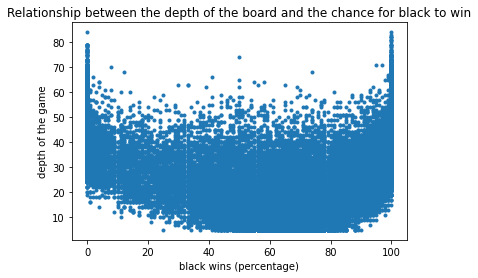

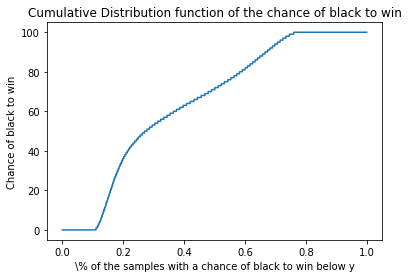

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.title("Relationship between the depth of the board and the chance for black to win")
plt.plot([sample["black_wins"] for sample in data],[sample["depth"] for sample in data], '.')
plt.xlabel("black wins (percentage)")
plt.ylabel("depth of the game")


# Cumulative Distribution function of the chance of black to win
cdf_wins = sorted([sample["black_wins"] for sample in data])
plt.figure()
plt.plot([x/len(cdf_wins) for x in range(len(cdf_wins))], cdf_wins)
plt.title("Cumulative Distribution function of the chance of black to win")
plt.xlabel("\% of the samples with a chance of black to win below y")
plt.ylabel("Chance of black to win")
print("The CDF curve shows that black has more chances to win, globally")

# First steps: transform all the data into np arrays to feed your neural network

(désolé je viens de me rendre compte que je viens de passer en anglais :))

Advices:
- do not use only a single 9x9 matrix as input. Use at least two planes to encode the board. One plane for black and one plane for white (typically with a 1 if there is a black stone for the first plane and with a 1 if there is a white stone for the second plane). The dimension of an input should be at least `[9,9,2]` as it is proposed in the example below. Of course you can use a more interesting encoding of the board into tensors.
- if you have time, you could consider to enrich your dataset with all symmetries and rotations. You should be able to multiply the number of samples to consider: any rotation of the board should have the same score, right?
- what should happen on the score if you switch the colors? To know which player has to play next, you can check, for a sample, the parity of the length of the list `data[i]["list_of_moves"]` (an odd length list would mean that white is the next player. An even length list means that black has to play).
- work on enlarging and preparing your data only once. Once all you input data is setup as a big np matrix, you may want to save it for speeding up everything. You can use, for instance `np.rot90()` and `np.flipud()` to generate all the symmetries



In [4]:
import numpy as np

def name_to_coord(s):
    assert s != "PASS"
    indexLetters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'J':8}

    col = indexLetters[s[0]]
    lin = int(s[1:]) - 1
    return col, lin

 # Vous pouvez utiliser votre propre fonction ici si vous voulez utiliser un autre encodage
def json_to_numpy(sample):
  to_return = np.zeros((9,9,2))
  indices = ["black_stones", "white_stones"]
  for plane, name in enumerate(indices):
    for coord_name in sample[name]:
      x, y = name_to_coord(coord_name)
      to_return[x,y,plane] = 1
  return to_return

print("Par exemple voici ce que va donner notre encodage pour l'exemple 10:")
print(data[10])
encoded = json_to_numpy(data[10])

print("La matrice résultat est de dimension")
print(encoded.shape)
print("Plan 0 du tenseur : contient les pieces contenant une pierre noire sur l'exemple 10")
print(encoded[:,:,0])
print("Les positions des pierres sont ", data[10]["black_stones"])
print()
print("Plan 1 du tenseur : contient les pieces contenant une pierre blanche sur l'exemple 10")
print(encoded[:,:,1])
print("Les positions des pierres sont ", data[10]["white_stones"])

print()

Par exemple voici ce que va donner notre encodage pour l'exemple 10:
{'depth': 8, 'list_of_moves': ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7'], 'black_stones': ['B7', 'C6', 'E5', 'C3'], 'white_stones': ['C8', 'E7', 'H7', 'G3'], 'rollouts': 100, 'black_wins': 60, 'black_points': 876.0, 'white_wins': 40, 'white_points': 378.0}
La matrice résultat est de dimension
(9, 9, 2)
Plan 0 du tenseur : contient les pieces contenant une pierre noire sur l'exemple 10
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Les positions des pierres sont  ['B7', 'C6', 'E5', 'C3']

Plan 1 du tenseur : contient les pieces contenant une pierre blanche sur l'exemple 10
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [

## Données en entrée et en sortie de votre modèle final

Même si en interne, votre modèle va manipuler des tenseurs en np, vous devrez construire une boite noire qui prendra en entrée un élément json décrivant les coordonnées des pierres noires et blanche et **donnera le pourcentage de chance pour noir** de gagner depuis cette position. On ne cherche pas à prédire la moyenne des scores, mais seulement le pourcentage de victoire (donc un flottant entre 0 et 1) !

Ainsi, pour l'exemple `i` :
- Vous prendez en entree `data[i]`
- Vous devrez prédire simplement `data[i]["black_wins"]/data[i]["rollouts"]`

Encore une fois, **attention** : en interne, il faudra absolument construire vos données formattées en matrices np pour faire votre entrainement. On vous demande juste ici d'écrire comment vous faites ces transformations, pour comprendre ce que vous avez décidé de mettre en entrée du réseau.

### Exemple de cellule permettant de genérer le fichier qu'il faudra donner

Voici le modèle de la fonction qui pourra être appelée, au final (Attention, ce n'est qu'un exemple, vous pourrez par exemple avoir une fonction qui prend plus de paramètres en entrée pour produire votre prédiction):


In [5]:
# Ce bout de code produit (X, Y)
# Pour retrouver vos habitudes


np.random.seed(12345)  # A changer pour ne pas mélanger toujours pareil

X = []
Y = []
for d in data:
  X.append(json_to_numpy(d))
  Y.append(d["black_wins"] / d["rollouts"])

X = np.array(X)
Y = np.array(Y)


print(X.shape)
print(Y.shape)


X_to_predict = []
for d in data_to_evaluate:
  X_to_predict.append(json_to_numpy(d))
X_to_predict = np.array(X_to_predict)

print("Et voici les 1000 exemples à prédire, prêts à passer dans votre réseau")
print(X_to_predict.shape)

(41563, 9, 9, 2)
(41563,)
Et voici les 1000 exemples à prédire, prêts à passer dans votre réseau
(1000, 9, 9, 2)


# Second steps: build your neural network and train it

Don't forget to check overfitting, ...

*advices* :
- you need to test Dense and Conv2D layers (the best models may contain convolution layers=
- if you use convolution layers, be sure not to downsize your board. Applying a filter should keep the original size of the board (9x9), otherwise you would somehow forget the stones on the borders
- you will use like 33% of your input sample for validation. However, the final goal is to score new data that will be given in addition to the actual data. So, you should use the 33% splitting rule to set up your network architecture and, once you fixed it, you should train your final model on the whole set of data, crossing your fingers that it will generalize well.
- Warning: if you launch the fit function from keras more than once, it will not reset the weights and the biases of your neural network. It's good news because you can add more and more epochs to your model, but be careful about the training/test sets: each time you call fit() with validation_split set up to something like 0.33, it will choose a **new** partition of the samples. So you are breaking your validation/training partition! We advice you to use the `sklearn.model_selection.train_test_split()` method to split the set of examples just once and then use the parameter `validation_data` in the call for `fit()`.  Thus you will be able to call it multiple time.


In [11]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
import tensorflow.keras.optimizers as optimizers

model = Sequential()

input_dim=(9,9,1)
#Conv2D
model.add(Conv2D( 64, (3,3), input_shape=(9,9,2), activation='relu'))
model.add(Conv2D( 128, (3,3), input_shape=(9,9,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 7, 7, 64)          1216      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 3200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               819456    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

# Now we can build our sets for training

In [12]:
def position_predict(description):
    # Cette méthode doit prendre une description de partie (un élément de l'ensemble 
    # des exemples donnés en format JSON) et va produire la prédiction de victoire

    # ... Votre tambouille interne pour placer les pierres comme il faut dans votre structure de données
    # et appeler votre modèle Keras (typiquement avec model.predict())
    # Si vous utilisez la fonction de base donéee ci-dessus, cela pourra être
    input = json_to_numpy(description)
 
    # input est ici un seul exemple. Votre modèle demandant un ensemble d'exemples
    # il faudra étendre ses dimensions pour que model recoivent un tenseur contenant
    # un seul exemple : on utilse expand_dims pour dire qu'au lieu d'avoir x 
    # on a en fait [x]
    # Si (comme on l'a fait) on a un X qui a les dimensions (9,9,2)
    #  alors on aura un tenseur aux dimensions (1,9,9,2)
    input = np.expand_dims(input, axis=0)
  
    prediction = model.predict(input) # Ne marchera que si model est correctement defini
    
    return prediction[0] # De même ici on réduit la dimension de sortie

# Par exemple, nous pourrons appeler votre prédiction ainsi
for i in range(10):
    print("Prediction this sample:")
    summary_of_example(data, i)
    print()
    prediction = position_predict(data[i])
    print("You predicted", prediction, "and the actual target was", data[i]["black_wins"]/data[i]["rollouts"])

# Ainsi, pour le rendu, en admettant que newdata soit le fichier json contenant
# les plateaux à prédire vous pourrez construire le fichier resultat ainsi
# vérifiez tout de même que la sortie est ok avant de la soumettre

def create_result_file(newdata):
    ''' Exemple de méthode permettant de générer le fichier de resultats demandés. '''
    resultat  = [position_predict(d["black_stones"], d["white_stones"]) for d in newdata]
    with open("my_predictions.txt", "w") as f:
         for p in resultat:
            f.write(str(p)+"\n")
            

Prediction this sample:
Sample 0

Données brutes en format JSON: {'depth': 41, 'list_of_moves': ['C6', 'G3', 'D3', 'E7', 'F3', 'G4', 'G7', 'C8', 'F6', 'B6', 'B5', 'E6', 'D5', 'F8', 'H6', 'F2', 'E2', 'H2', 'F5', 'F4', 'E3', 'B7', 'E5', 'G8', 'H8', 'A5', 'G9', 'B4', 'C5', 'H5', 'G5', 'C2', 'H4', 'C7', 'F9', 'E9', 'H9', 'C4', 'F1', 'C3', 'F7'], 'black_stones': ['F9', 'G9', 'H9', 'H8', 'F7', 'G7', 'C6', 'F6', 'H6', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H4', 'D3', 'E3', 'F3', 'E2', 'F1'], 'white_stones': ['E9', 'C8', 'F8', 'G8', 'B7', 'C7', 'E7', 'B6', 'E6', 'A5', 'H5', 'B4', 'C4', 'F4', 'G4', 'C3', 'G3', 'C2', 'F2', 'H2'], 'rollouts': 100, 'black_wins': 84, 'black_points': 1034.0, 'white_wins': 16, 'white_points': 296.0}

The sample was obtained after 41 moves
The successive moves were ['C6', 'G3', 'D3', 'E7', 'F3', 'G4', 'G7', 'C8', 'F6', 'B6', 'B5', 'E6', 'D5', 'F8', 'H6', 'F2', 'E2', 'H2', 'F5', 'F4', 'E3', 'B7', 'E5', 'G8', 'H8', 'A5', 'G9', 'B4', 'C5', 'H5', 'G5', 'C2', 'H4', 'C7', 'F9

You predicted [0.26101714] and the actual target was 0.63
Prediction this sample:
Sample 6

Données brutes en format JSON: {'depth': 38, 'list_of_moves': ['D3', 'C6', 'B4', 'F7', 'G4', 'B5', 'A3', 'H7', 'F5', 'F6', 'C4', 'C7', 'E5', 'H5', 'E6', 'E7', 'H4', 'G5', 'A5', 'A6', 'A4', 'J4', 'J3', 'J5', 'G3', 'D6', 'D5', 'C5', 'H2', 'J6', 'D4', 'B8', 'G2', 'A7', 'J1', 'B7', 'F4', 'G6'], 'black_stones': ['E6', 'A5', 'D5', 'E5', 'F5', 'A4', 'B4', 'C4', 'D4', 'F4', 'G4', 'H4', 'A3', 'D3', 'G3', 'J3', 'G2', 'H2', 'J1'], 'white_stones': ['B8', 'A7', 'B7', 'C7', 'E7', 'F7', 'H7', 'A6', 'C6', 'D6', 'F6', 'G6', 'J6', 'B5', 'C5', 'G5', 'H5', 'J5', 'J4'], 'rollouts': 100, 'black_wins': 0, 'black_points': 0, 'white_wins': 100, 'white_points': 100.0}

The sample was obtained after 38 moves
The successive moves were ['D3', 'C6', 'B4', 'F7', 'G4', 'B5', 'A3', 'H7', 'F5', 'F6', 'C4', 'C7', 'E5', 'H5', 'E6', 'E7', 'H4', 'G5', 'A5', 'A6', 'A4', 'J4', 'J3', 'J5', 'G3', 'D6', 'D5', 'C5', 'H2', 'J6', 'D4', 'B8'

# Last step

Prepare your model to predict the set of new data to predict, and predict the file with the 1000 examples to predict!

(may be you would like to express, when guessing the percentage of wins for blacks, that it should reflect the fact that this score should be the same for all the symmetries you considered)...

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# Plutot que X_train, Y_train et X_test, Y_test on passe tous les exemples
# et on demande à keras de découper en deux ensembles (training et test)
# grâce au paramètre validation_split
# Bien entendu il faudra plus de 20 epochs, mais c'est à vous de modifier cela !
model.fit(X, Y, epochs=30, validation_split=0.33)

Epoch 1/30
871/871 [==============================] - 11s 12ms/step - loss: 0.1488 - accuracy: 0.2355 - val_loss: 0.0826 - val_accuracy: 0.2620
Epoch 2/30
871/871 [==============================] - 11s 13ms/step - loss: 0.0873 - accuracy: 0.2825 - val_loss: 0.0708 - val_accuracy: 0.2855
Epoch 3/30
871/871 [==============================] - 12s 14ms/step - loss: 0.0740 - accuracy: 0.2990 - val_loss: 0.0605 - val_accuracy: 0.2967
Epoch 4/30
871/871 [==============================] - 11s 12ms/step - loss: 0.0672 - accuracy: 0.3059 - val_loss: 0.0596 - val_accuracy: 0.3017
Epoch 5/30
871/871 [==============================] - 12s 13ms/step - loss: 0.0627 - accuracy: 0.3090 - val_loss: 0.0565 - val_accuracy: 0.3015
Epoch 6/30
871/871 [==============================] - 11s 13ms/step - loss: 0.0601 - accuracy: 0.3131 - val_loss: 0.0511 - val_accuracy: 0.3051
Epoch 7/30
871/871 [==============================] - 11s 13ms/step - loss: 0.0551 - accuracy: 0.3177 - val_loss: 0.0519 - val_accuracy: